In [17]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score, RocCurveDisplay,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

In [2]:
data = pd.read_csv('../data/ds_challenge_data.csv')
data.head()
data = data.rename(columns={'converions':'conversions'})
data = data[data['cost']>0] #removing no cost rows
data['CPC'] = data['cost']/data['clicks']
data['CPA'] = data['cost']/data['conversions'].replace(0, np.nan)

In [3]:
data.nunique()
data.sort_values('conversions',ascending=False)

,date,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions,CPC,CPA
9346,2020-03-11,13409820,412000,Marketing,564,2c493,12691367,719.338082,2003.537308,43,0.359034,16.728793
18469,2020-03-24,14005008,412000,Marketing,564,2c493,12712080,616.305213,512.791677,33,1.201863,18.675916
25979,2020-03-25,13194852,419000,Marketing,564,2c493,12743356,183.070224,540.101496,32,0.338955,5.720944
41136,2020-01-30,13263117,419000,Marketing,564,cf11d,12711092,774.669183,603.209826,27,1.284245,28.691451
40923,2020-03-11,14005235,412000,Marketing,564,2c493,12711091,444.387286,1149.678790,27,0.386532,16.458788
...,...,...,...,...,...,...,...,...,...,...,...,...
15515,2020-03-11,13195906,413000,Marketing,564,cf11d,12775684,3.787414,8.036954,0,0.471250,NaN
15516,2019-12-27,13244643,291060,Health Science,653,2c493,12775562,2.320671,1.004619,0,2.310000,NaN
15518,2020-01-05,13409389,171000,Manufacturing,185,d7fa7,12775684,0.492264,2.009239,0,0.245000,NaN
15519,2019-11-06,13173882,131000,Finance,288,2c493,12775684,1.195498,1.004620,0,1.190000,NaN


<h3>Objective</h3>
<ul> Maximize conversions, while</ul>
<ul> Minimizing CPA (cost per application)</ul>
    <h3>Manipulable Parameters</h3>
You may experiment with and optimize:
    <ul> Publishers – e.g., identifying higher-performing platforms </ul>
<ul> Markets – e.g., identifying higher-performing locations</ul>
<ul> Categories – what works best for each campaign category that yields the best results</ul>
<ul> CPC (Cost-per-click) – when we post a campaign in any ad platform, we send a bid,
which is the highest cost-per-click (CPC) we’re willing to pay, the actual CPC value can be treated as a variable representing the bid sent.

In [4]:
#Publishers
publisher_gdf = data.groupby(['publisher'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)
publisher_gdf['CPC'] = publisher_gdf['cost']/publisher_gdf['clicks']
publisher_gdf['CPA'] = publisher_gdf['cost']/publisher_gdf['conversions']

publisher_gdf.head(10)

/var/folders/4g/0fmhxfxx42g94gyd3c3g336h0000gn/T/ipykernel_5649/2413185871.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  publisher_gdf = data.groupby(['publisher'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)


,cost,clicks,conversions,CPC,CPA
publisher,,,,,
2c493,71218.881294,149752.124945,3829,0.475578,18.599865
2b764,21271.719230,29379.477384,960,0.724033,22.158041
d7fa7,13679.005124,22515.584202,625,0.607535,21.886408
cf11d,13370.400747,24096.608312,801,0.554867,16.692136
cd0ec,11055.649441,21597.225312,587,0.511901,18.834156
28377,7716.196362,8775.317155,126,0.879307,61.239654
28b5f,5733.511394,6167.090943,696,0.929695,8.237804
a17bf,4567.027011,7868.176109,148,0.580443,30.858291
8c421,4408.567639,6338.273078,175,0.695547,25.191815


In [5]:
#Markets
markets_gdf = data.groupby(['market_id'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)
markets_gdf['CPC'] = markets_gdf['cost']/markets_gdf['clicks']
markets_gdf['CPA'] = markets_gdf['cost']/markets_gdf['conversions']

markets_gdf.head(10)

/var/folders/4g/0fmhxfxx42g94gyd3c3g336h0000gn/T/ipykernel_5649/1541335118.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  markets_gdf = data.groupby(['market_id'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)


,cost,clicks,conversions,CPC,CPA
market_id,,,,,
12698400,1643.427332,2268.772497,85,0.724369,19.334439
12698397,1530.561897,2861.771812,88,0.534830,17.392749
12690718,1150.353432,831.965699,30,1.382693,38.345114
12763724,1144.594708,783.051602,3,1.461710,381.531569
12691644,1029.238555,1945.693171,42,0.528983,24.505680
12711092,980.624666,1013.137168,38,0.967909,25.805912
12698396,939.351284,1652.099176,35,0.568580,26.838608
12698399,896.212132,1419.653012,40,0.631290,22.405303
12693996,885.306314,968.747725,14,0.913867,63.236165


In [6]:
#Markets
category_gdf = data.groupby(['category_id'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)
category_gdf['CPC'] = category_gdf['cost']/category_gdf['clicks']
category_gdf['CPA'] = category_gdf['cost']/category_gdf['conversions']

category_gdf.head(10)

/var/folders/4g/0fmhxfxx42g94gyd3c3g336h0000gn/T/ipykernel_5649/2139297333.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  category_gdf = data.groupby(['category_id'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)


,cost,clicks,conversions,CPC,CPA
category_id,,,,,
419000,48090.754079,84682.111986,2637,0.567897,18.236918
413000,35235.843600,65221.779111,2176,0.540247,16.192943
171000,22866.941200,41559.897827,1180,0.550216,19.378764
412000,18965.461693,38340.657921,1200,0.494657,15.804551
131000,8286.481270,12048.127513,291,0.687782,28.475881
100000,5961.432345,10542.266187,211,0.565479,28.253234
532000,3575.010250,5610.505235,119,0.637199,30.042103
291020,2516.322364,3700.235099,65,0.680044,38.712652
151100,2247.694347,4210.329379,51,0.533852,44.072438


/var/folders/4g/0fmhxfxx42g94gyd3c3g336h0000gn/T/ipykernel_5649/313112155.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  date_gdf = data.groupby(['date'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)


,cost,clicks,conversions,CPC,CPA
date,,,,,
2020-03-17,5561.139617,13372.972187,361,0.415849,15.404819
2020-03-24,4740.027093,6021.392952,189,0.787198,25.079508
2020-03-11,4352.896501,9934.325541,220,0.438167,19.785893
2020-03-26,3282.643341,4842.075171,144,0.677941,22.796134
2020-03-25,3152.086439,4973.176547,220,0.633818,14.327666
2020-02-11,3026.475891,3294.740298,136,0.918578,22.253499
2020-03-09,3023.193385,4508.814908,113,0.670507,26.753924
2020-02-03,2994.336347,3279.843429,84,0.912951,35.646861
2020-03-04,2807.223068,5312.622756,156,0.528406,17.995020


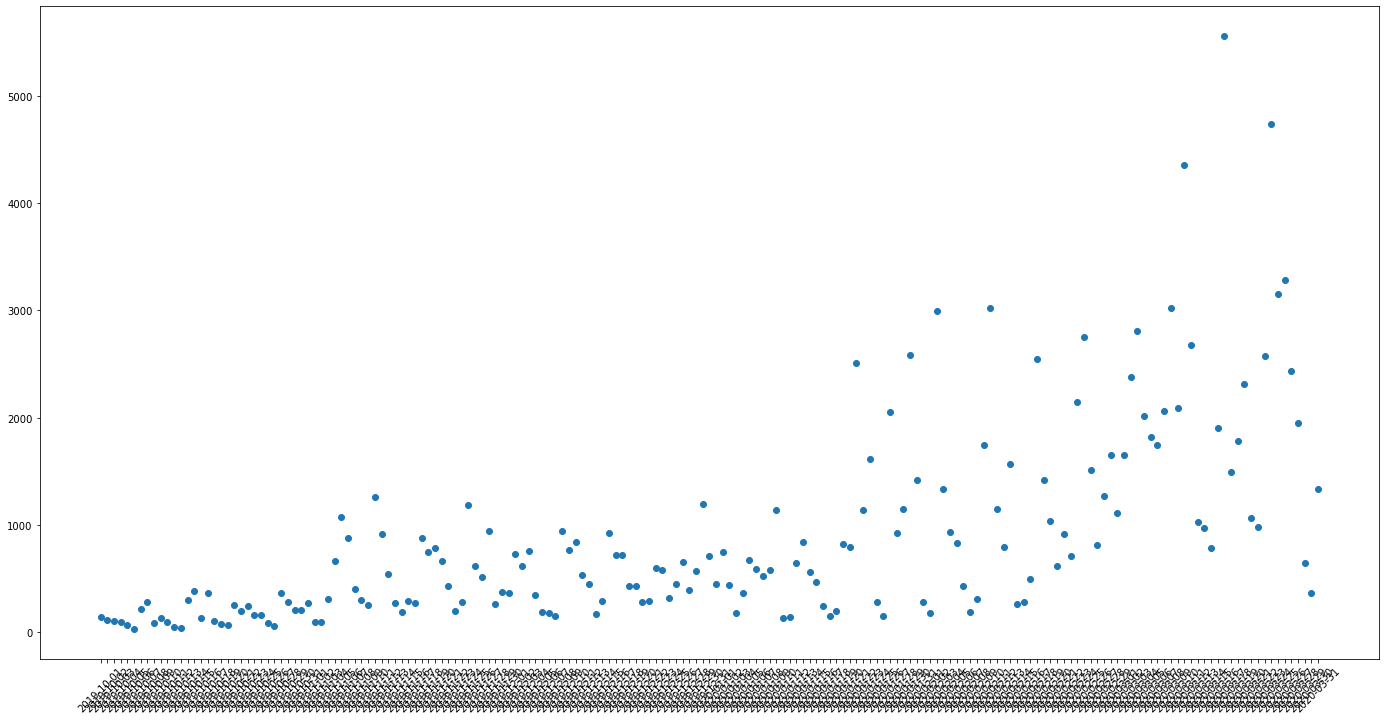

In [7]:
#Dates

date_gdf = data.groupby(['date'])['cost','clicks','conversions'].sum().sort_values('cost',ascending=False)
date_gdf['CPC'] = date_gdf['cost']/date_gdf['clicks']
date_gdf['CPA'] = date_gdf['cost']/date_gdf['conversions']

display(date_gdf.head(10))
date_gdf.reset_index(inplace=True)
date_gdf=date_gdf.sort_values('date',ascending=True)
plt.figure(figsize=(24, 12))
plt.xticks(rotation=45)
plt.scatter(x=date_gdf['date'],y=date_gdf['cost'])

In [8]:
data = pd.get_dummies(data,columns=['category_id','industry','publisher','customer_id','market_id'])
data.head()

,date,campaign_id,cost,clicks,conversions,CPC,CPA,category_id_100000,category_id_131000,category_id_151100,...,market_id_12777760,market_id_12777762,market_id_12777772,market_id_12777832,market_id_12777937,market_id_12777939,market_id_12777944,market_id_12777965,market_id_12777966,market_id_12777967
0,2020-01-13,13438542,0.550000,1.000000,0,0.550000,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-14,13263546,1.240000,3.000001,0,0.413333,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-12-26,13582620,4.184004,12.000011,0,0.348667,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-29,14050177,1.590002,4.000005,0,0.397500,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-12-06,12946962,1.037769,1.000001,0,1.037767,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = data.drop(['date','campaign_id','cost','clicks','conversions','CPA'],axis=1)
yCPA = data['CPA']
yCPAny = data['CPA']>0
display(X.head())
display(yCPA.head())
display(yCPAny.unique())

,CPC,category_id_100000,category_id_131000,category_id_151100,category_id_152000,category_id_171000,category_id_172010,category_id_172050,category_id_172070,category_id_172080,...,market_id_12777760,market_id_12777762,market_id_12777772,market_id_12777832,market_id_12777937,market_id_12777939,market_id_12777944,market_id_12777965,market_id_12777966,market_id_12777967
0,0.550000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.413333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.348667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.397500,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.037767,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: CPA, dtype: float64

array([False,  True])

In [10]:
#Classifier to see if there is a conversion
X_train, X_test, y_train, y_test = train_test_split(X, yCPAny, test_size=0.2, random_state=42,stratify=yCPAny)
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]

In [11]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [12]:
# XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

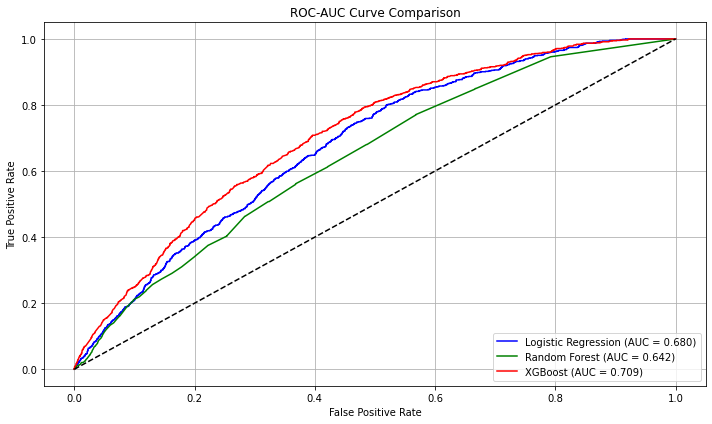

In [13]:

# Compute ROC curves and AUCs
models = {
    "Logistic Regression": (lr_probs, "blue"),
    "Random Forest": (rf_probs, "green"),
    "XGBoost": (xgb_probs, "red")
}

plt.figure(figsize=(10, 6))
for name, (probs, color) in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})", color=color)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
#Moving forward to Regresssor to predict CPA
df_reg = data[data["CPA"] > 0].copy()

X_reg = df_reg.drop(columns=['date','campaign_id','cost','clicks','conversions','CPA'])
y_reg = df_reg["CPA"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train XGBoost regressor
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(Xr_train, yr_train)

# Evaluate
yr_pred = xgb_reg.predict(Xr_test)
mae = mean_absolute_error(yr_test, yr_pred)
rmse = mean_squared_error(yr_test, yr_pred, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 6.46
RMSE: 12.96


In [ ]:
#### DECISION ALGO
def recommend_market_and_publisher(customer_id, industry, category_id, base_features, model_clf, model_reg, all_markets, all_publishers):
    candidates = []
    
    for market_id in all_markets:
        for publisher_id in all_publishers:
            row = base_features.copy()
            row.update({
                "customer_id": customer_id,
                "industry": industry,
                "category_id": category_id,
                "market_id": market_id,
                "publisher_id": publisher_id
            })
            

            # Predict conversion
            prob = model_clf.predict_proba(row)[0][1]

            # Predict CPA (only if conversion likely)
            if prob > 0.5:
                predicted_cpa = model_reg.predict(row)[0]
            else:
                predicted_cpa = np.inf

            # Score
            score = prob / predicted_cpa if predicted_cpa > 0 else 0
            candidates.append({
                "market_id": market_id,
                "publisher_id": publisher_id,
                "probability": prob,
                "predicted_cpa": predicted_cpa,
                "score": score
            })
    
    # Sort and return best
    candidates = sorted(candidates, key=lambda x: -x["score"])
    return candidates[0] if candidates else None
recommend_market_and_publisher(customer_id, industry, category_id, base_features, model_clf, model_reg, all_markets, all_publishers)